# >>> Work in process <<<

### Analyzing ordinal data with metric models: What could possibly go wrong?

Kruschke, J. K., & Liddell, T. (2018, April 5). Ordinal Data Analysis. Retrieved from http://osf.io/53ce9

PyMC3 implementation of the ordinal probit model.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

from IPython.display import Image
from theano.compile.ops import as_op
from scipy.stats import norm

%matplotlib inline

color = '#87ceeb'
f_dict = {'size':14}

Function `gammaShRaFromModeSD` ported from https://osf.io/eujgd/

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [3]:
# Read data file directly from https://osf.io.
data = pd.read_csv('https://osf.io/38ue2/download', skiprows=1, usecols=np.arange(1,8))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
Descrip       36 non-null object
N             36 non-null int64
5starPrcnt    36 non-null int64
4starPrcnt    36 non-null int64
3starPrcnt    36 non-null int64
2starPrcnt    36 non-null int64
1starPrcnt    36 non-null int64
dtypes: int64(6), object(1)
memory usage: 2.0+ KB


In [4]:
data.head()

,Descrip,N,5starPrcnt,4starPrcnt,3starPrcnt,2starPrcnt,1starPrcnt
0,The Whole Truth,700,35,31,17,10,7
1,Priceless,745,77,8,3,3,9
2,Allied,846,48,24,12,9,7
3,The Infiltrator,4318,48,31,12,5,4
4,Miss Sloane,1202,66,10,4,5,15


In [5]:
# Convert the precentages to counts with help of N column. Order the columns.
y = (data.iloc[:,2:7]
     .divide(100)
     .multiply(data.iloc[:,1], axis=0)
     .round()
     .astype(int)
     .iloc[:,::-1])
y.columns = y.columns.map(lambda x: x[:5])

y.head()

,1star,2star,3star,4star,5star
0,49,70,119,217,245
1,67,22,22,60,574
2,59,76,102,203,406
3,173,216,518,1339,2073
4,180,60,48,120,793


In [6]:
z = y.sum(axis=1)
z.head()

0     700
1     745
2     846
3    4319
4    1201
dtype: int64

In [7]:
Ncases = data.index.size
Ncases

36

In [8]:
# Number of outcomes
nYlevels = y.columns.size
nYlevels

5

In [9]:
gammaShRa = gammaShRaFromModeSD(3,3)
gammaShRa

(2.6180339887498949, 0.53934466291663163)

#### Lower panel of figure 1
*A latent scale on the horizontal axis is divided into subintervals with thresholds marked by
dashed lines. The cumulative normal probability in the subintervals is the probability of the
ordinal values. The cumulative normal probability mass within each interval is indicated
by the height of the corresponding bar, with numerical scale indicated on the right vertical
axis.* 
(Kruschke & Liddell, 2018, April 5)

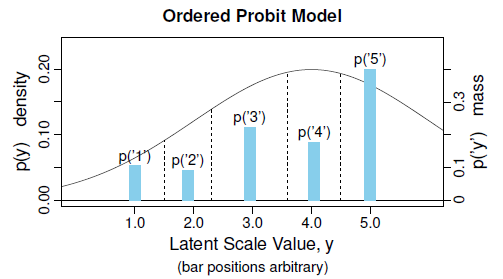

In [19]:
Image('Ordered_Probit_Model.png')

### Model - JAGS 
(Kruschke & Liddell, 2018, April 5)  
https://osf.io/mvsc3/


```
# THE *ORDERED PROBIT* MODEL:
modelString = "
  model {
    for ( i in 1:Ncases ) {
      y[i, ] ~ dmulti( pr[i,1:nYlevels] , z[i] )
      pr[i,1] <- pnorm( thresh[1] , mu[x[i]] , 1/sigma[x[i]]^2 )
      for ( k in 2:(nYlevels-1) ) {
        pr[i,k] <- max( 0 ,  pnorm( thresh[ k ] , mu[x[i]] , 1/sigma[x[i]]^2 )
                           - pnorm( thresh[k-1] , mu[x[i]] , 1/sigma[x[i]]^2 ) )
      }
      pr[i,nYlevels] <- 1 - pnorm( thresh[nYlevels-1] , mu[x[i]] , 1/sigma[x[i]]^2 )
    }
    for ( j in 1:Ncases ) { 
      mu[j] ~ dnorm( (1+nYlevels)/2 , 1/(nYlevels)^2 )
      sigma[j] ~ dgamma( sigmaSh , sigmaRa )
    }
    sigmaSh <- 1 + sigmaMode * sigmaRa
    sigmaRa <- ( ( sigmaMode + sqrt( sigmaMode^2 + 4*sigmaSD^2 ) ) 
                / ( 2*sigmaSD^2 ) )
    sigmaMode ~ dgamma( gammaShRa[1] , gammaShRa[2] ) 
    sigmaSD ~ dgamma( gammaShRa[1] , gammaShRa[2] ) 
    for ( k in 2:(nYlevels-2) ) {  # 1 and nYlevels-1 are fixed, not stochastic
      thresh[k] ~ dnorm( k+0.5 , 1/2^2 )
    }
  }
" # close quote for modelString
```

### Model - PyMC3

In [10]:
# Thresholds, masking the the inner two values. 
thresh = [k + .5 for k in range(1, nYlevels)]
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

thresh:		[1.5, 2.5, 3.5, 4.5]
thresh_obs:	[1.5 -- -- 4.5]


In [11]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dvector], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((nYlevels, Ncases))
    n = norm(loc=mu, scale=sigma)
    lbound = np.repeat(0, Ncases)
    
    # Thresholded cumulative normal probabilities.
    # Four thresholds (theta values) define the 5 outcome probabilities.
    out[0,:] = n.cdf(theta[0])        
    out[1,:] = np.max([lbound, n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[2,:] = np.max([lbound, n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[3,:] = np.max([lbound, n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[4,:] = 1 - n.cdf(theta[3])

    return out

In [12]:
with pm.Model() as ordinal_model_multi_groups:    
           
    mu = pm.Normal('mu', mu=(1+nYlevels)/2.0, tau=1.0/(nYlevels)**2, shape=Ncases)
    
    sigmaSD = pm.Gamma('sigmaSD', gammaShRa[0], gammaShRa[1])
    sigmaMode = pm.Gamma('sigmaMode', gammaShRa[0], gammaShRa[1])
    sigmaRa = pm.Deterministic('sigmaRa', (sigmaMode + pm.math.sqrt(sigmaMode**2 + 4*sigmaSD**2)) / 2*sigmaSD**2)
    sigmaSh = pm.Deterministic('sigmaSh', 1 + sigmaMode*sigmaRa)
    sigma = pm.Gamma('sigma', sigmaSh, sigmaRa, shape=Ncases)
    
    theta = pm.Normal('theta', mu=thresh, tau=1/np.repeat(2**2, len(thresh)),
                      shape=len(thresh), observed=thresh_obs)#, testval=thresh)
    
    pr = outcome_probabilities(theta, mu, sigma)
    
    out = pm.Multinomial('out', n=z.values.reshape(-1,1), p=pr.T, observed=y.values)  

C:\Users\jxwarme\AppData\Local\Continuum\anaconda3\envs\jwv\lib\site-packages\theano\tensor\basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [13]:
with ordinal_model_multi_groups:
    step1 = pm.Metropolis()
    trace = pm.sample(1000, step=step1, cores=1, progressbar=True)    

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [theta_missing]
>Metropolis: [sigma_log__]
>Metropolis: [sigmaMode_log__]
>Metropolis: [sigmaSD_log__]
>Metropolis: [mu]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:21<00:00, 69.12it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
